In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 180)

TM_PATH = "../../raw_data_agust_tm/"
TW_PATH = "../../raw_data_agust_12/"
WY_PATH = "../../raw_data_agust_wy/"
TM_PATH_2 = "../../tm_data_filip/"

df_tm_filip = pd.read_parquet(f"{TM_PATH_2}transfer_history_tm.parquet")

In [2]:
df_tm_filip.shape

(1139, 14)

In [3]:
df_tm_filip.head()

,player_id,team_id_from,team_id_to,competition_id_from,competition_country_from,competition_id_to,competition_country_to,age_at_transfer,transfer_fee,transfer_value,dateremaining_contract_period,contract_until_date,season,date_of_transfer
0,371003,281,447,GB1,189,KR1,37,18,NaN,550000,1606.0,2020-06-30T00:00:00+02:00,2018.0,2019-02-05T00:00:00+01:00
1,371003,447,281,KR1,37,GB1,189,18,6300000.0,550000,1246.0,2023-06-30T00:00:00+02:00,2018.0,2019-01-31T00:00:00+01:00
2,371003,18894,447,KR2,37,KR1,37,18,NaN,0,730.0,2022-06-30T00:00:00+02:00,2018.0,2018-07-01T00:00:00+02:00
3,355816,281,202,GB1,189,NL1,122,21,NaN,700000,1627.0,2021-06-30T00:00:00+02:00,2018.0,2019-01-15T00:00:00+01:00
4,355816,9598,281,JAP1,77,GB1,189,21,1100000.0,700000,382.0,2023-06-30T00:00:00+02:00,2018.0,2019-01-14T00:00:00+01:00


In [4]:
df_tm_filip.isna().mean().sort_values(ascending=False)

transfer_fee                     0.735733
dateremaining_contract_period    0.107989
contract_until_date              0.045654
player_id                        0.000000
team_id_from                     0.000000
team_id_to                       0.000000
competition_id_from              0.000000
competition_country_from         0.000000
competition_id_to                0.000000
competition_country_to           0.000000
age_at_transfer                  0.000000
transfer_value                   0.000000
season                           0.000000
date_of_transfer                 0.000000
dtype: float64

In [5]:
df_tm_filip.dtypes

player_id                         object
team_id_from                      object
team_id_to                        object
competition_id_from               object
competition_country_from           int64
competition_id_to                 object
competition_country_to             int64
age_at_transfer                    int64
transfer_fee                     float64
transfer_value                     int64
dateremaining_contract_period    float64
contract_until_date               object
season                           float64
date_of_transfer                  object
dtype: object

In [6]:
# mismo equipo from y to
(df_tm_filip["team_id_from"] == df_tm_filip["team_id_to"]).mean()

np.float64(0.0)

In [7]:
# misma competición from y to
(df_tm_filip["competition_id_from"] == df_tm_filip["competition_id_to"]).mean()

np.float64(0.05179982440737489)

In [8]:
df_tm_filip["season"].value_counts().sort_index()
df_tm_filip["date_of_transfer"].min(), df_tm_filip["date_of_transfer"].max()

('2018-07-01T00:00:00+02:00', '2025-07-14T00:00:00+02:00')

### Transfermarkt Transfers (Filip) – Data Quality Check

- One row per transfer event (event-level dataset).
- High missingness in `transfer_fee` (~74%), expected due to non-public or free transfers.
- Moderate missingness in contract-related fields:
  - `dateremaining_contract_period` (~11%)
  - `contract_until_date` (~5%)
- No missing values in core identifiers (player, team, competition, season).
- No problematic exact or semantic duplicates detected.

## 2) Linear Regression Models

In [9]:
# Get features

df = df_tm_filip.copy()

# parse robusto (convierte inválidos a NaT)
df["date_of_transfer"] = pd.to_datetime(df["date_of_transfer"], errors="coerce", utc=True)
df["contract_until_date"] = pd.to_datetime(df["contract_until_date"], errors="coerce", utc=True)

# sanity rápido de tipos y NaT
print(df["date_of_transfer"].dtype, df["contract_until_date"].dtype)
print("NaT date_of_transfer:", df["date_of_transfer"].isna().mean())
print("NaT contract_until_date:", df["contract_until_date"].isna().mean())

# años restantes
delta = df["contract_until_date"] - df["date_of_transfer"]
df["contract_years_remaining"] = delta.dt.total_seconds() / (365.25 * 24 * 3600)

# quedarnos con valores válidos
df = df[df["contract_years_remaining"] > 0]

datetime64[ns, UTC] datetime64[ns, UTC]
NaT date_of_transfer: 0.0
NaT contract_until_date: 0.0456540825285338


In [10]:
# Linear Regression Function

def run_model(df, X_cols, y_col, label):
    d = df.dropna(subset=X_cols + [y_col]).copy()
    d = d[d[y_col] > 0]

    X = d[X_cols]
    y = np.log(d[y_col].astype(float))

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    Xtr, Xte, ytr, yte = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    model = LinearRegression().fit(Xtr, ytr)
    yhat = model.predict(Xte)

    print(f"\n{label}")
    print("N:", len(d))
    print("R²:", r2_score(yte, yhat))
    print(pd.DataFrame({"variable": X_cols, "coef": model.coef_}))

### 2.1) Model 1 - Age vs Transfer Value

In [11]:
run_model(
    df,
    X_cols=["age_at_transfer"],
    y_col="transfer_value",
    label="(1) Age → Transfer Value"
)


(1) Age → Transfer Value
N: 1038
R²: 0.01954441156523723
          variable      coef
0  age_at_transfer  0.250619


### 2.2) Model 2 - Age + Remaining Contract vs Transfer Value

In [12]:
run_model(
    df,
    X_cols=["age_at_transfer", "contract_years_remaining"],
    y_col="transfer_value",
    label="(2) Age + Remaining Contract → Transfer Value"
)


(2) Age + Remaining Contract → Transfer Value
N: 1038
R²: 0.04010354809053607
                   variable      coef
0           age_at_transfer  0.324258
1  contract_years_remaining  0.396493


### 2.3) Model 3 - Age + Remaining Contract + Signed Contract vs Transfer Value

In [13]:
run_model(
    df,
    X_cols=[
        "age_at_transfer",
        "contract_years_remaining",
        "dateremaining_contract_period"  # si decides mantenerla como proxy adicional
    ],
    y_col="transfer_value",
    label="(3) Age + Remaining + Contract Length → Transfer Value"
)


(3) Age + Remaining + Contract Length → Transfer Value
N: 974
R²: 0.10386869051317194
                        variable      coef
0                age_at_transfer  0.410786
1       contract_years_remaining  0.399309
2  dateremaining_contract_period  0.291858


### 2.4) Model 4 - Age + Remaining Contract + Signed Contract + Destination League vs Transfer Value

In [14]:
X = df[[
    "age_at_transfer",
    "contract_years_remaining",
    "competition_id_to",
    "transfer_value"
]].dropna()

X = X[X["transfer_value"] > 0]

y = np.log(X["transfer_value"])

X_fe = pd.get_dummies(
    X[["age_at_transfer", "contract_years_remaining", "competition_id_to"]],
    columns=["competition_id_to"],
    drop_first=True
)

scaler = StandardScaler()
X_fe[["age_at_transfer", "contract_years_remaining"]] = scaler.fit_transform(
    X_fe[["age_at_transfer", "contract_years_remaining"]]
)

Xtr, Xte, ytr, yte = train_test_split(
    X_fe, y, test_size=0.2, random_state=42
)

model = LinearRegression().fit(Xtr, ytr)
yhat = model.predict(Xte)

print("\n(4) Age + Contract + League Fixed Effects → Transfer Value")
print("N:", len(X))
print("R²:", r2_score(yte, yhat))


(4) Age + Contract + League Fixed Effects → Transfer Value
N: 1038
R²: 0.19513170621334508


### 2.5) Model 5 - Age + Remaining Contract + Signed Contract + Destination League + Origin League vs Transfer Value

In [15]:
X = df[[
    "age_at_transfer",
    "contract_years_remaining",
    "competition_id_to",
    "competition_id_from",
    "transfer_value"
]].dropna()

X = X[X["transfer_value"] > 0]
y = np.log(X["transfer_value"])

X_fe = pd.get_dummies(
    X[[
        "age_at_transfer",
        "contract_years_remaining",
        "competition_id_to",
        "competition_id_from",
    ]],
    columns=["competition_id_to", "competition_id_from"],
    drop_first=True
)

# estandarizar solo continuas
scaler = StandardScaler()
X_fe[["age_at_transfer", "contract_years_remaining"]] = scaler.fit_transform(
    X_fe[["age_at_transfer", "contract_years_remaining"]]
)

Xtr, Xte, ytr, yte = train_test_split(X_fe, y, test_size=0.2, random_state=42)

model = LinearRegression().fit(Xtr, ytr)
print("(5) + Origin league FE")
print("R²:", r2_score(yte, model.predict(Xte)))

(5) + Origin league FE
R²: 0.39909525013306024


### 2.6) Model 6 - Age + Remaining Contract + Signed Contract + Destination League + Origin League + Proximity to deadline vs Transfer Value

In [16]:
d = df.copy()

# asegurar tz-aware
d["date_of_transfer"] = pd.to_datetime(d["date_of_transfer"], errors="coerce", utc=True)

m = d["date_of_transfer"].dt.month
d["window"] = np.select(
    [m.isin([1, 2]), m.isin([6, 7, 8, 9])],
    ["winter", "summer"],
    default="other"
)

# deadline tz-aware desde el inicio
d["deadline"] = pd.Series(pd.NaT, index=d.index, dtype="datetime64[ns, UTC]")

year = d["date_of_transfer"].dt.year

winter_mask = d["window"] == "winter"
d.loc[winter_mask, "deadline"] = pd.to_datetime(
    year[winter_mask].astype(str) + "-01-31", utc=True
)

summer_mask = d["window"] == "summer"
d.loc[summer_mask, "deadline"] = pd.to_datetime(
    year[summer_mask].astype(str) + "-08-31", utc=True
)

# delta robusto (en días)
delta = d["deadline"] - d["date_of_transfer"]
d["days_to_deadline"] = delta.dt.total_seconds() / (24 * 3600)

# proxies
d["last_30_days"] = ((d["days_to_deadline"] >= 0) & (d["days_to_deadline"] <= 30)).astype(int)
d["last_14_days"] = ((d["days_to_deadline"] >= 0) & (d["days_to_deadline"] <= 14)).astype(int)

# sanity
print(d["window"].value_counts(dropna=False))
print(d["days_to_deadline"].describe())

window
summer    669
winter    261
other     147
Name: count, dtype: int64
count    930.000000
mean      28.479167
std       26.079040
min      -28.916667
25%        1.083333
50%       23.083333
75%       61.083333
max       82.083333
Name: days_to_deadline, dtype: float64


In [17]:
# --- construir X y filtrar filas válidas ---
X = d[[
    "age_at_transfer",
    "contract_years_remaining",
    "competition_id_to",
    "competition_id_from",
    "last_30_days",
    "transfer_value",
]].copy()

# target válido
X = X.dropna()
X = X[X["transfer_value"] > 0]

y = np.log(X["transfer_value"].astype(float))

# por si acaso (deja 0 dudas)
mask = np.isfinite(y)
X = X.loc[mask].copy()
y = y.loc[mask].copy()

# --- dummies league FE ---
X_fe = pd.get_dummies(
    X[[
        "age_at_transfer",
        "contract_years_remaining",
        "competition_id_to",
        "competition_id_from",
        "last_30_days",
    ]],
    columns=["competition_id_to", "competition_id_from"],
    drop_first=True
)

# estandarizar continuas
scaler = StandardScaler()
X_fe[["age_at_transfer", "contract_years_remaining"]] = scaler.fit_transform(
    X_fe[["age_at_transfer", "contract_years_remaining"]]
)

# train/test
Xtr, Xte, ytr, yte = train_test_split(X_fe, y, test_size=0.2, random_state=42)

model = LinearRegression().fit(Xtr, ytr)
yhat = model.predict(Xte)

print("(6) + Deadline proxy (last_30_days)")
print("N:", len(X_fe))
print("R²:", r2_score(yte, yhat))

coef = pd.Series(model.coef_, index=X_fe.columns)
print("coef(last_30_days):", float(coef.loc["last_30_days"]))

(6) + Deadline proxy (last_30_days)
N: 1038
R²: 0.4016696571684232
coef(last_30_days): 0.08782492266699604


## 3) Models Summary

In [18]:

model_perf = pd.DataFrame({
    "model": [
        "Age",
        "Age + Remaining contract",
        "Age + Remaining + Contract length",
        " + League FE (to)",
        " + League FE (to + from)",
        " + Deadline proxy"
    ],
    "r2": [
        0.0195,
        0.0401,
        0.1039,
        0.1951,
        0.3991,
        0.4017
    ]
})

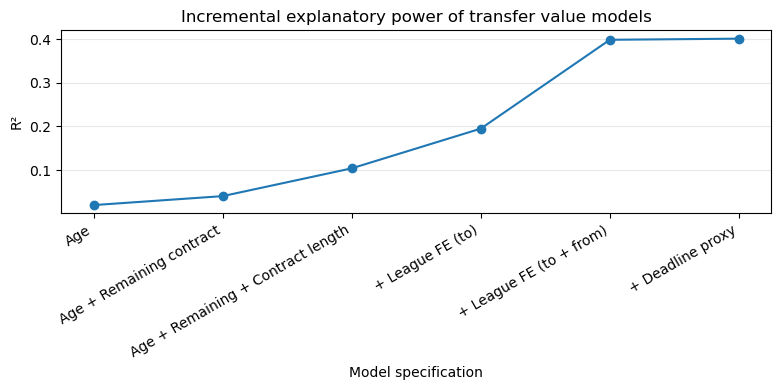

In [19]:
plt.figure(figsize=(8,4))

plt.plot(
    model_perf["model"],
    model_perf["r2"],
    marker="o"
)

plt.ylabel("R²")
plt.xlabel("Model specification")
plt.title("Incremental explanatory power of transfer value models")

plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

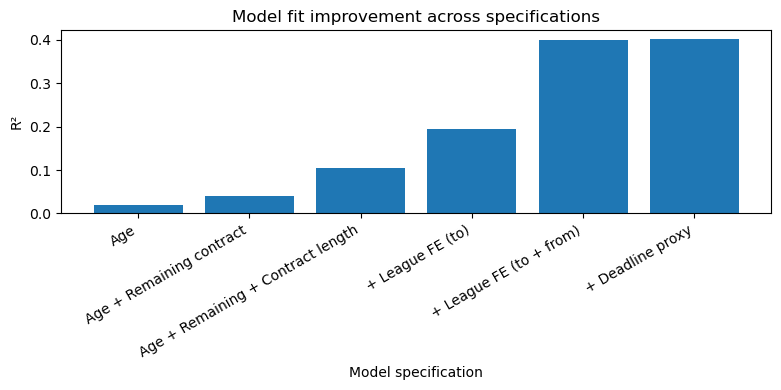

In [20]:
plt.figure(figsize=(8,4))

plt.bar(
    model_perf["model"],
    model_perf["r2"]
)

plt.ylabel("R²")
plt.xlabel("Model specification")
plt.title("Model fit improvement across specifications")

plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()